In [15]:
# generate a bunch of source mechanisms: 
# strike: 0-360, dip: 0-90, rake: -180-180
# tensor moving up in dip by 25 degrees

In [16]:
from numpy import *
import matplotlib.pyplot as plt
from obspy import taup
from obspy.imaging.beachball import beachball, beach
#from obspy.taup import TauPyModel
#from obspy.taup.velocity_model import VelocityModel
import functions as fx
#import importlib

In [17]:
eps =1e-10; halfpi = pi/2; twopi = 2*pi
i_hat = array([1,0,0]); j_hat = array([0,1,0]); k_hat = array([0,0,1])

In [18]:
hdepth = 15
epdist = 10
azimuth = 200
modelname = 'ak135'

In [19]:
# ?? how to get the velocity model ??

velmodel = taup.velocity_model.VelocityModel.read_tvel_file('/Users/suzan/anaconda3/pkgs/obspy-1.3.1-py310h936d966_0/lib/python3.10/site-packages/obspy/taup/data/'+modelname+'.tvel')
velmodel.model_name = modelname

#print(velmodel.model_name, velmodel.min_radius, velmodel.max_radius)
#print(velmodel.moho_depth, velmodel.cmb_depth, velmodel.iocb_depth)
#print(velmodel.layers)
#laynum = velmodel.layer_number_below(hdepth)[0]
#print(laynum)
#print(velmodel.is_discontinuity(hdepth))
#print(velmodel.depth_at_top(layer=laynum),velmodel.depth_at_bottom(layer=laynum))
alpha = velmodel.evaluate_below(depth=hdepth,prop='p')[0]
beta = velmodel.evaluate_below(depth=hdepth,prop='s')[0]
print(alpha,beta)

model = taup.TauPyModel(model=modelname)
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                                  distance_in_degree=epdist, phase_list=['P', 'S'])
if len(arrivals) != 2:
    print('WARNING: More than one body-wave path found')
    print('Using first P wave.')
    print('Second P wave will be wrongly assigned as the S wave takeoff anlge.')

takeoff_angles = [a.takeoff_angle for a in arrivals]
print(takeoff_angles)

config = (model, hdepth, epdist, azimuth, alpha, beta, takeoff_angles)

FileNotFoundError: /Users/suzan/anaconda3/pkgs/obspy-1.3.1-py310h936d966_0/lib/python3.10/site-packages/obspy/taup/data/ak135.tvel not found.

In [ ]:
def invert_per_mechanism(config, strike_quadrant, rake_quadrant, step_size, num_subplots=4, flag="unit"):
    '''
    Generate relevant subplots, changing source mechanism
    Strike and rake quadrants are 1-4
    Step_size is the grid search step size
    '''

    model, hdepth, epdist, azimuth, alpha, beta, takeoff_angles = config
    
    s0 = (strike_quadrant-1)*90.
    strikes = array([s0, s0+30, s0+45, s0+90])
    dips = arange(0,90,25)
    r0 = (rake_quadrant-3)*90.
    rakes = array([r0, r0+30, r0+45, r0+90])
    
    # I lowered the number of strikes etc dramatically during testing:
    strikes = array([0,90])
    dips = array([45,90])
    rakes = array([-90,0,90])
  

    sdr_sources = []
    for ss in strikes:
        for dd in dips:
            for rr in rakes:
                sdr_sources.append(array([ss, dd, rr]))
    
        
    # seismic velocity model

    #model = taup.TauPyModel(model='ak135')

    #hdepth = 15
    #epdist = 10
    #azimuth = 200

    #arrivals = model.get_travel_times(source_depth_in_km=hdepth,
    #                                distance_in_degree=epdist, phase_list=['P', 'S'])
    #takeoff_angles = [a.takeoff_angle for a in arrivals]
    #alpha, beta = 5.8000, 3.4600

    sdr_all = []
    
    # generate list of amplitude vectors
    Aos = []
    for sdr in sdr_sources:
        Aos.append(array(fx.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta])))
    # perform inversion for each amplitude vector

    threshold = 0.98

    # grid search
    s_range = arange(0, 360, step_size)
    d_range = arange(0, 90, step_size)
    r_range = arange(-180, 180, step_size)

    # sdr_grid: happens once no matter what
    sdr_grid = zeros((len(s_range), len(d_range), len(r_range), 3))
    amplitudes = zeros((len(s_range), len(d_range), len(r_range), 3))
    unit_amplitudes = zeros((len(s_range), len(d_range), len(r_range), 3))
    for i in range(len(s_range)):
        for j in range(len(d_range)):
            for k in range(len(r_range)):
                sdr = array([s_range[i], d_range[j], r_range[k]])
                sdr_grid[i, j, k, :] = sdr
                amplitude = fx.Rpattern(sdr, azimuth, takeoff_angles, [alpha, beta])
                amplitudes[i, j, k, :] = amplitude
                unit_amplitudes[i, j, k, :] = amplitude/linalg.norm(amplitude)
    if flag=="unit":
        unit_amp_plot = unit_amplitudes.reshape(-1, 3)
    else:
        amp_plot = amplitudes.reshape(-1, 3)

    # invert per figure
    fig_count = 0
    subplot_count = 0

    for dd in dips: # each slice (figure)
        fig, axes = plt.subplots(len(strikes), len(rakes),
                        subplot_kw={'projection': '3d'}, figsize=(20, 20))
        
        for s_ind, ss in enumerate(strikes): # each row (subplot)
            for r_ind, rr in enumerate(rakes): # each column (subplot)
                exact_count = fig_count*len(strikes)*len(rakes) + subplot_count
                high_amplitudes = []
                high_unit_amplitudes = []
                sdr_accept = []
                cossims = zeros((len(s_range), len(d_range), len(r_range)))
                
                for i in range(len(s_range)):
                    for j in range(len(d_range)):
                        for k in range(len(r_range)):
                            sdr = sdr_grid[i, j, k, :]
                            amplitude = amplitudes[i, j, k, :]
                            unit_amplitude = unit_amplitudes[i, j, k, :]
                            cossims[i, j, k] = fx.cossim(Aos[exact_count], amplitude)
                            if cossims[i, j, k] > threshold:
                                high_amplitudes.append(amplitude)
                                high_unit_amplitudes.append(unit_amplitude)
                                sdr_accept.append((sdr,cossims[i, j, k]))  # need to save the sdr for later plotting
                high_amplitudes = array(high_amplitudes).reshape(-1, 3)
                high_unit_amplitudes = array(high_unit_amplitudes).reshape(-1, 3)
                
                ax = axes[s_ind, r_ind]
                if flag=="unit":
                    ax.scatter(unit_amp_plot[:,0], unit_amp_plot[:,1], unit_amp_plot[:,2],
                            c=cossims, cmap='viridis', s=.5, alpha=.3, label="All amps") # reshape cossims?
                    ax.scatter(high_unit_amplitudes[:,0], high_unit_amplitudes[:,1], high_unit_amplitudes[:,2],
                            c='k', s=5, label='High amps')
                else:
                    ax.scatter(amp_plot[:,0], amp_plot[:,1], amp_plot[:,2],
                            c=cossims, cmap='viridis', s=.5, alpha=.3, label="All amps") # reshape cossims?
                    ax.scatter(high_amplitudes[:,0], high_amplitudes[:,1], high_amplitudes[:,2],
                            c='k', s=5, label='High amps')
                
                # add Ao to the scatter plot
                ax.scatter(Aos[exact_count][0], Aos[exact_count][1], Aos[exact_count][2],
                        c='r', s=10, label='Observed amp')
                ax.scatter(0, 0, 0, c='b', s=10, label='Origin')
                sdro = sdr_sources[exact_count]
                
                sdr_all.append([sdro,sdr_accept])
                
                ax.set_title(f'Strike: {ss}, Dip: {dd}, Rake: {rr}')
                ax.set_xlabel('AP')
                ax.set_ylabel('ASV')
                ax.set_zlabel('ASH')
                # ax.legend()
                
                subplot_count += 1
                
                if subplot_count == len(strikes)*len(rakes):
                    fig_count += 1
                    subplot_count = 0
                    plt.show()
                
                if fig_count == num_subplots:
                    break
    return sdr_all

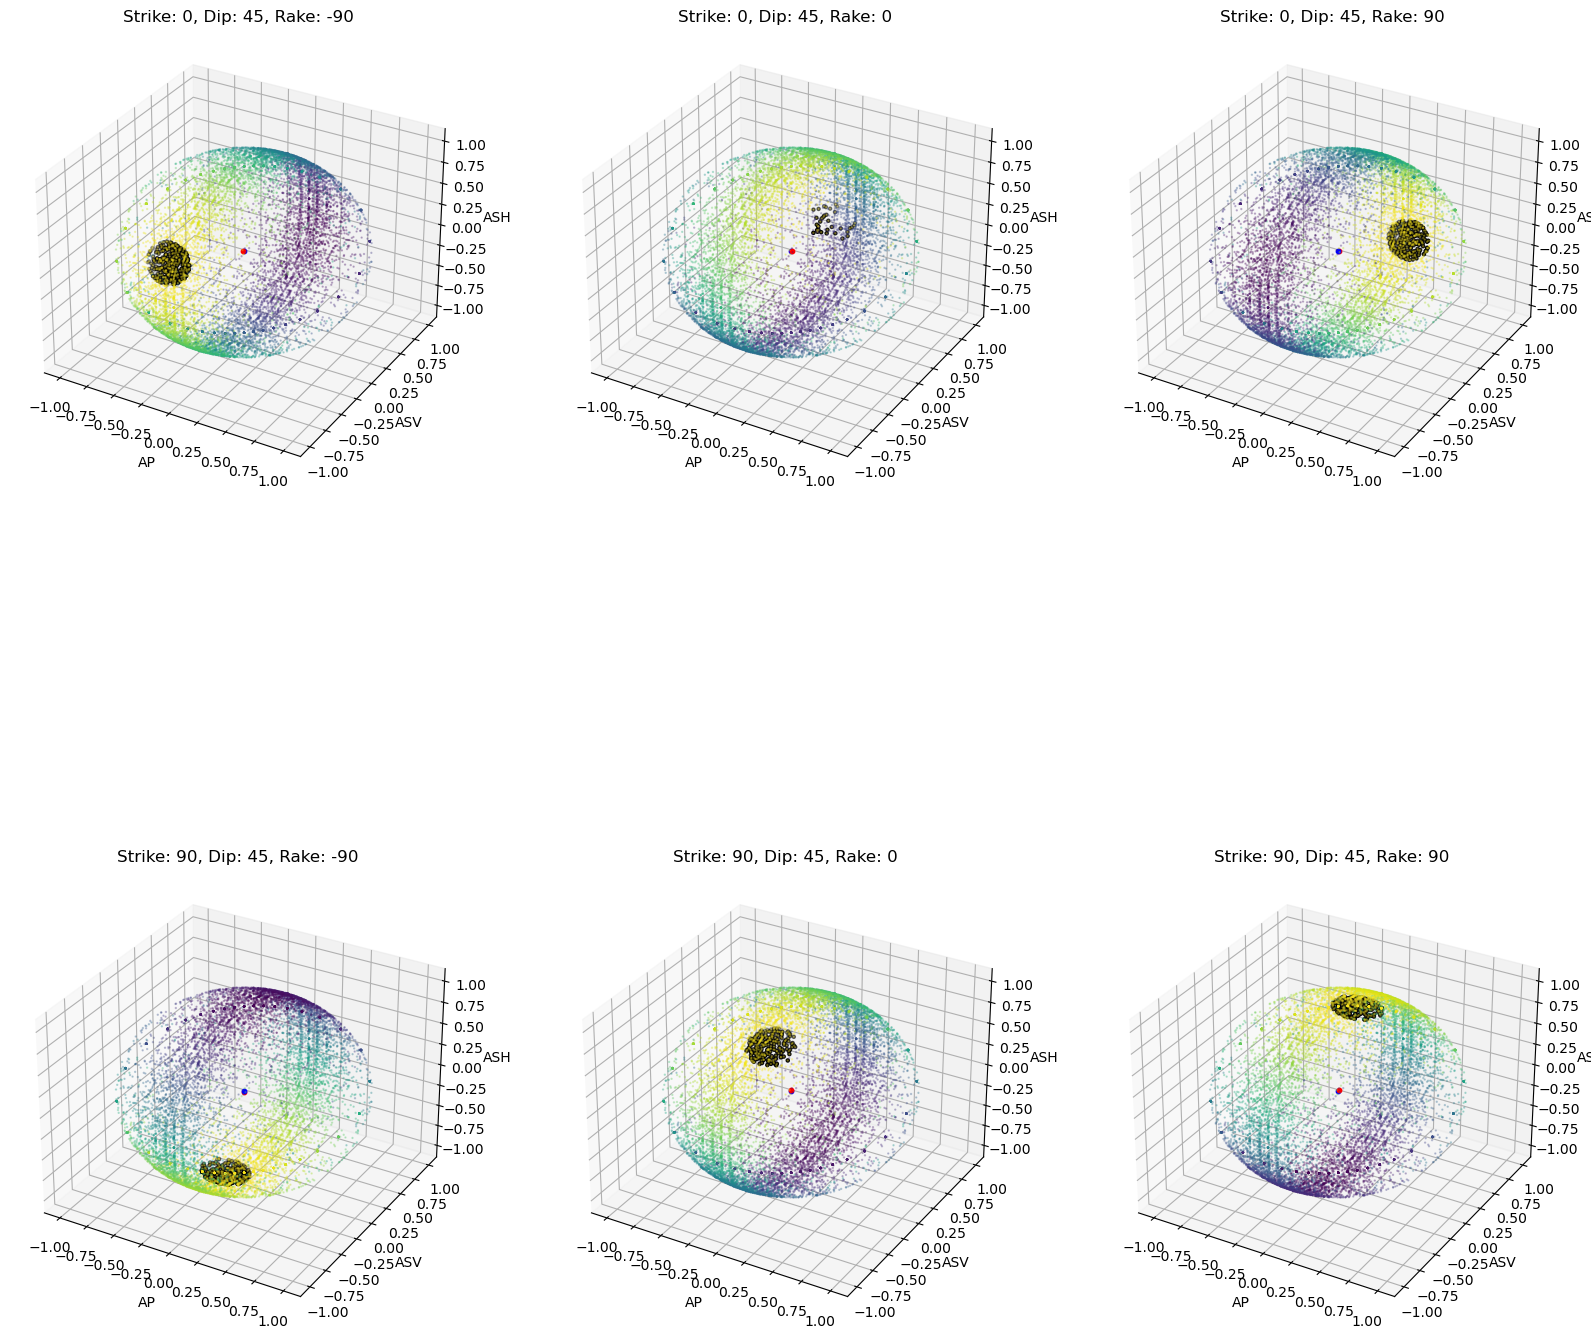

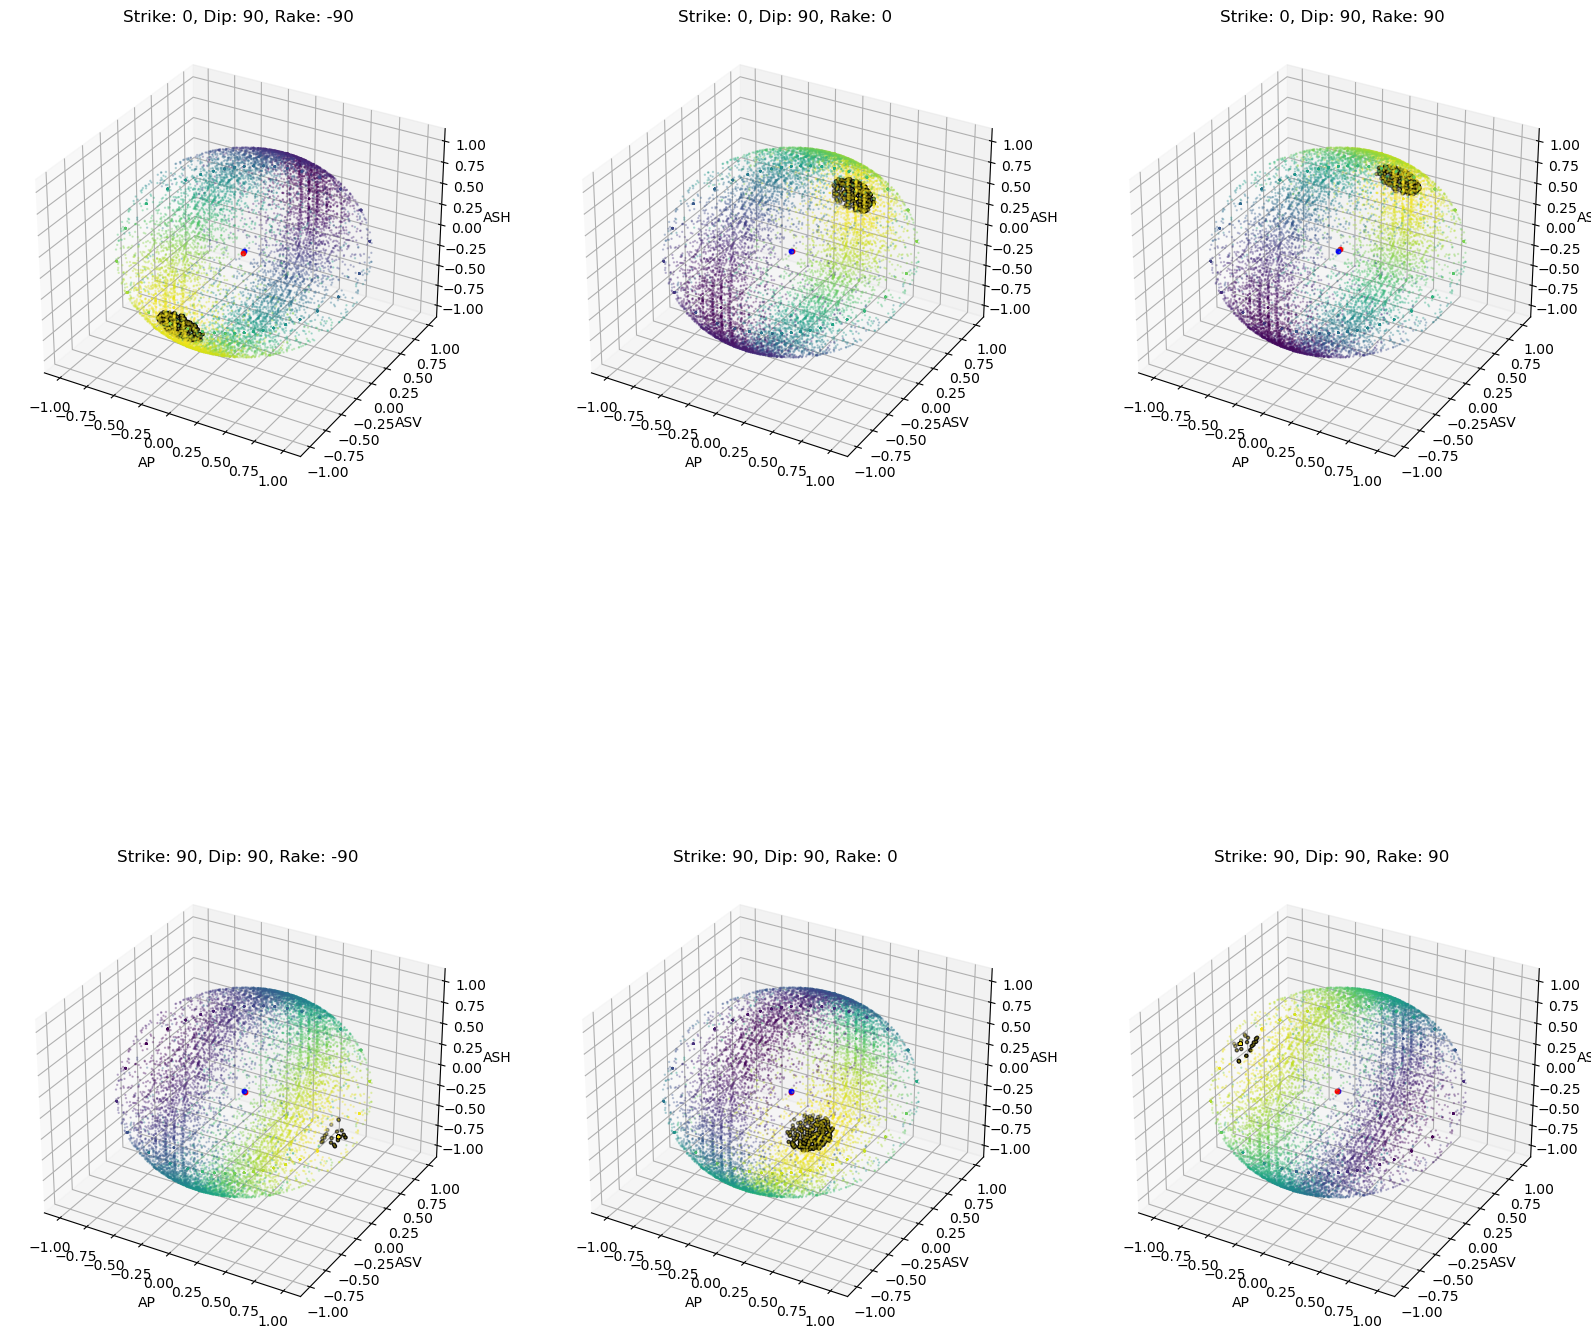

In [ ]:
sdr_all = invert_per_mechanism(config, strike_quadrant=1, rake_quadrant=4, step_size=10,flag="unit")

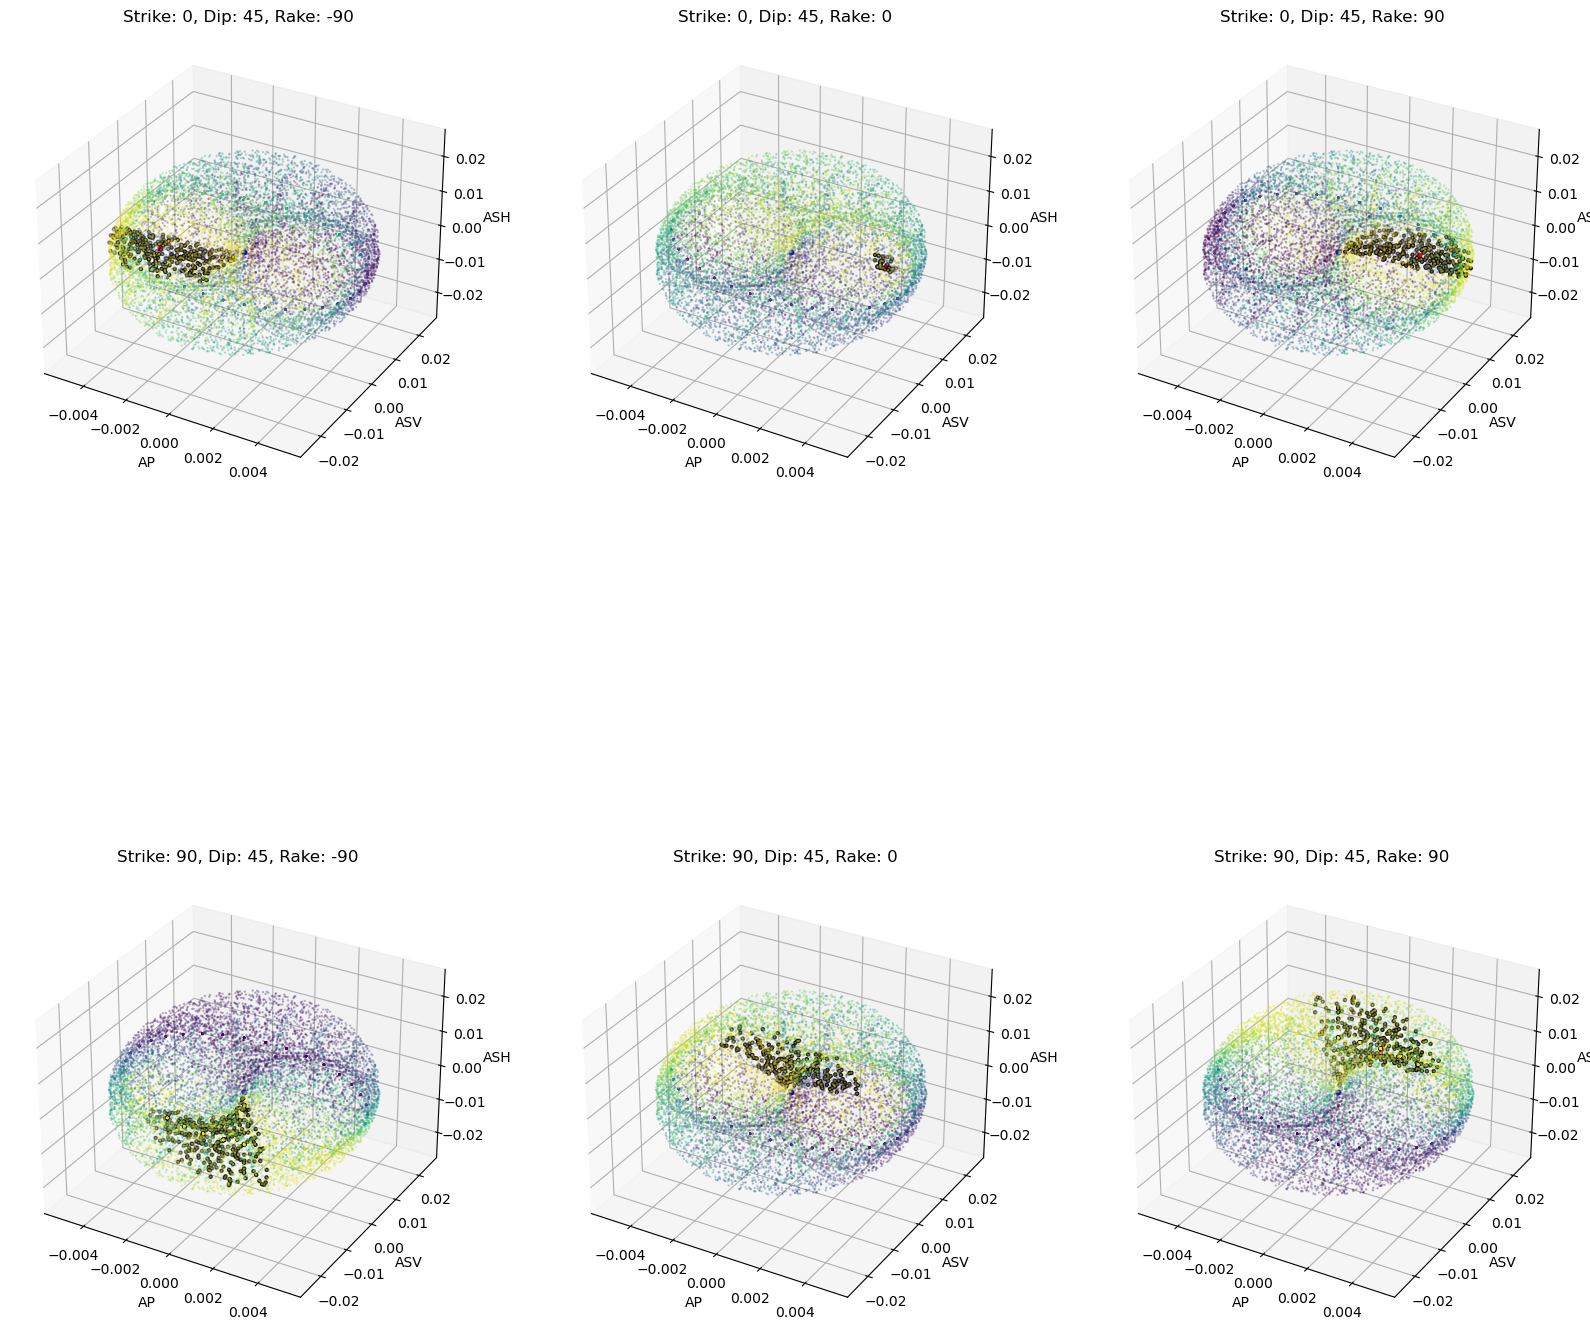

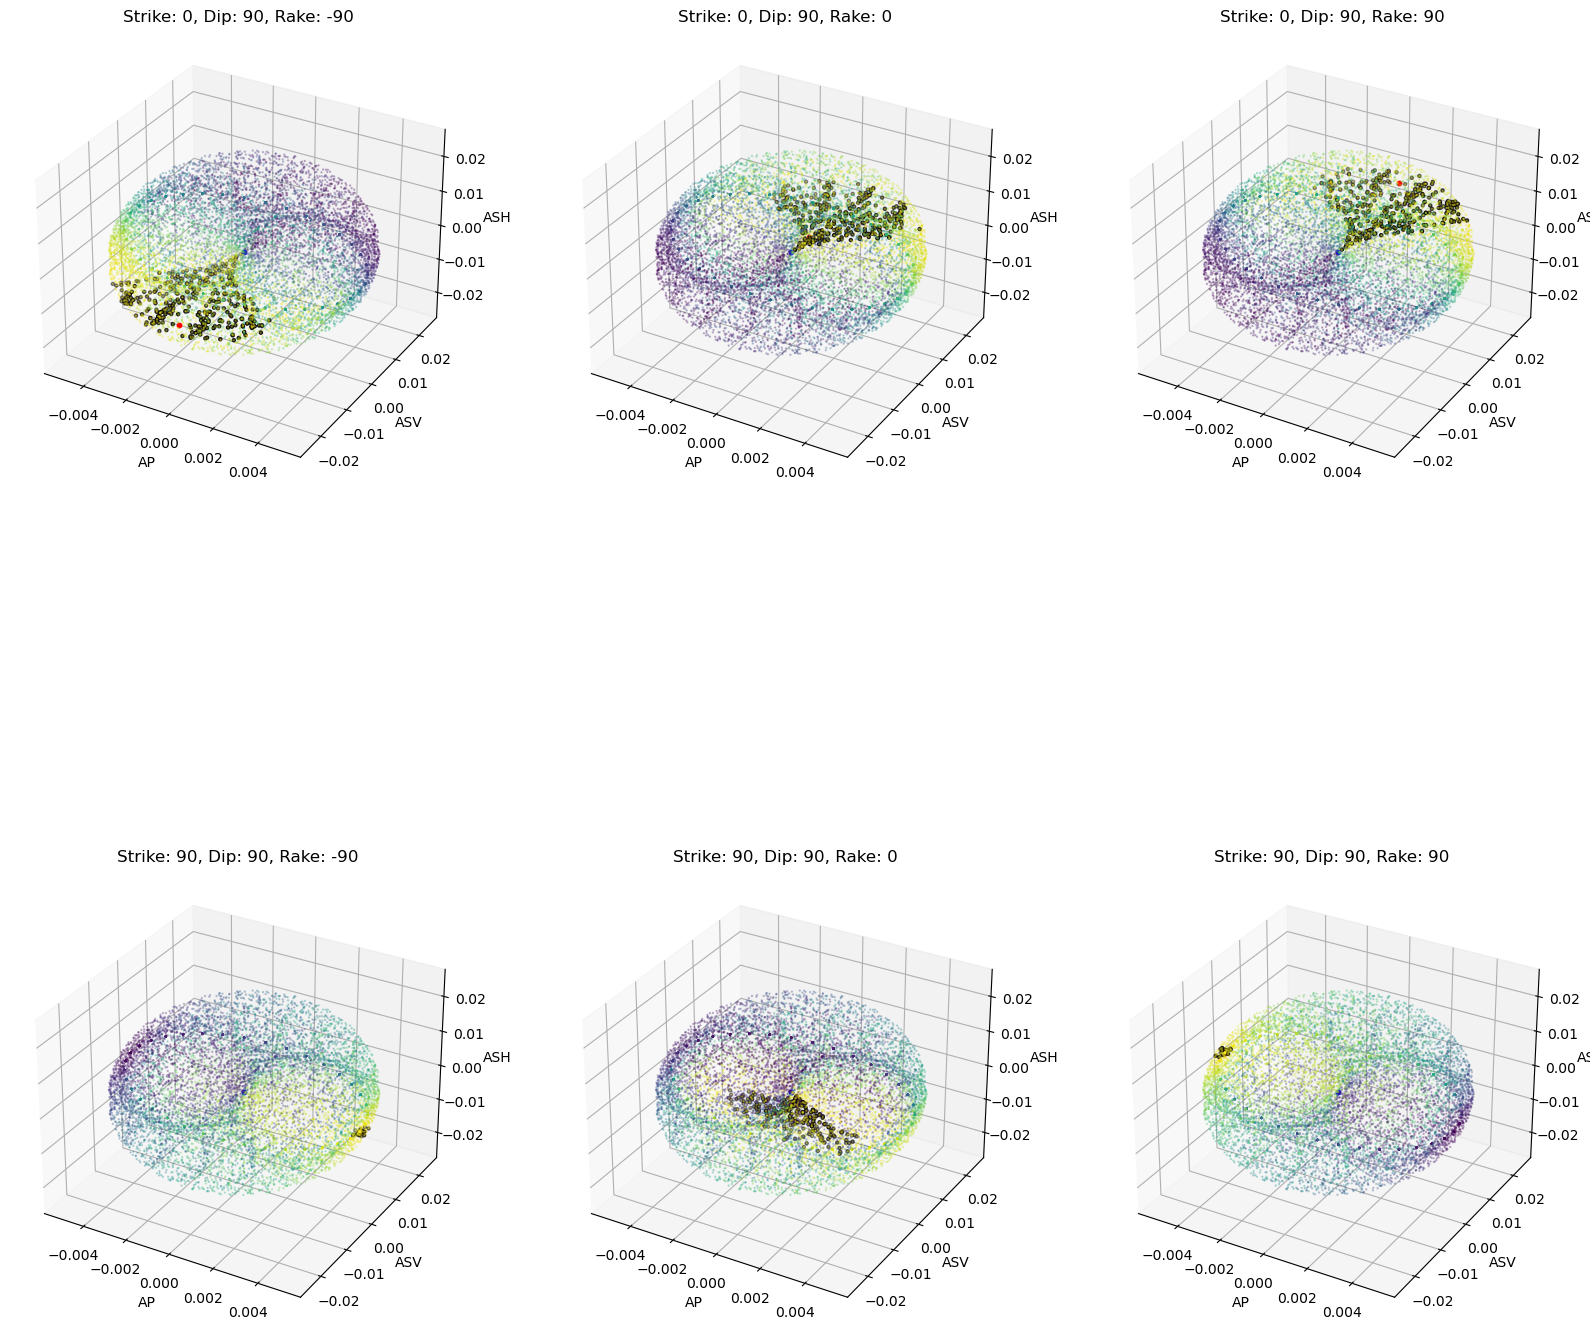

In [ ]:
sdr_all = invert_per_mechanism(config, strike_quadrant=1, rake_quadrant=4, step_size=10, flag="absolute")

In [ ]:
# each entry of sdr_all has: sdr_"observed",
# all tuples (sdr,cossim) for which cossim was above the threshold.
# sdr is in itself an array of strike, dip, rake

# print(sdr_all)
print(sdr_all[1])
ibb = 1
# in the following cells, explore just one observed sdr at a time, defined by ibb

[array([ 0, 45,  0]), [(array([  0.,  20., -30.]), 0.9956787483524838), (array([  0.,  20., -20.]), 0.986706745557245), (array([  0.,  30., -20.]), 0.9876039855807132), (array([  0.,  30., -10.]), 0.9873240484408928), (array([  0.,  40., -10.]), 0.9867626428969564), (array([ 0., 40.,  0.]), 0.9911952061298406), (array([ 0., 50.,  0.]), 0.9946856554141912), (array([ 110.,   80., -120.]), 0.9897085809789803), (array([ 120.,   80., -110.]), 0.9852988697988871), (array([ 120.,   80., -100.]), 0.9957784379105425), (array([130.,  80., -90.]), 0.9909816106510959), (array([ 240.,   20., -170.]), 0.9974030165837702), (array([ 240.,   30., -180.]), 0.9987850816567225), (array([240.,  40., 170.]), 0.9947050028935671), (array([ 250.,   20., -160.]), 0.9810474223443431), (array([250.,  70., 150.]), 0.9854469360150596), (array([ 260.,   10., -150.]), 0.9832157790708248), (array([ 260.,   10., -140.]), 0.9912772249445146), (array([260.,  80., 150.]), 0.9952809436818916), (array([ 270.,   10., -140.])

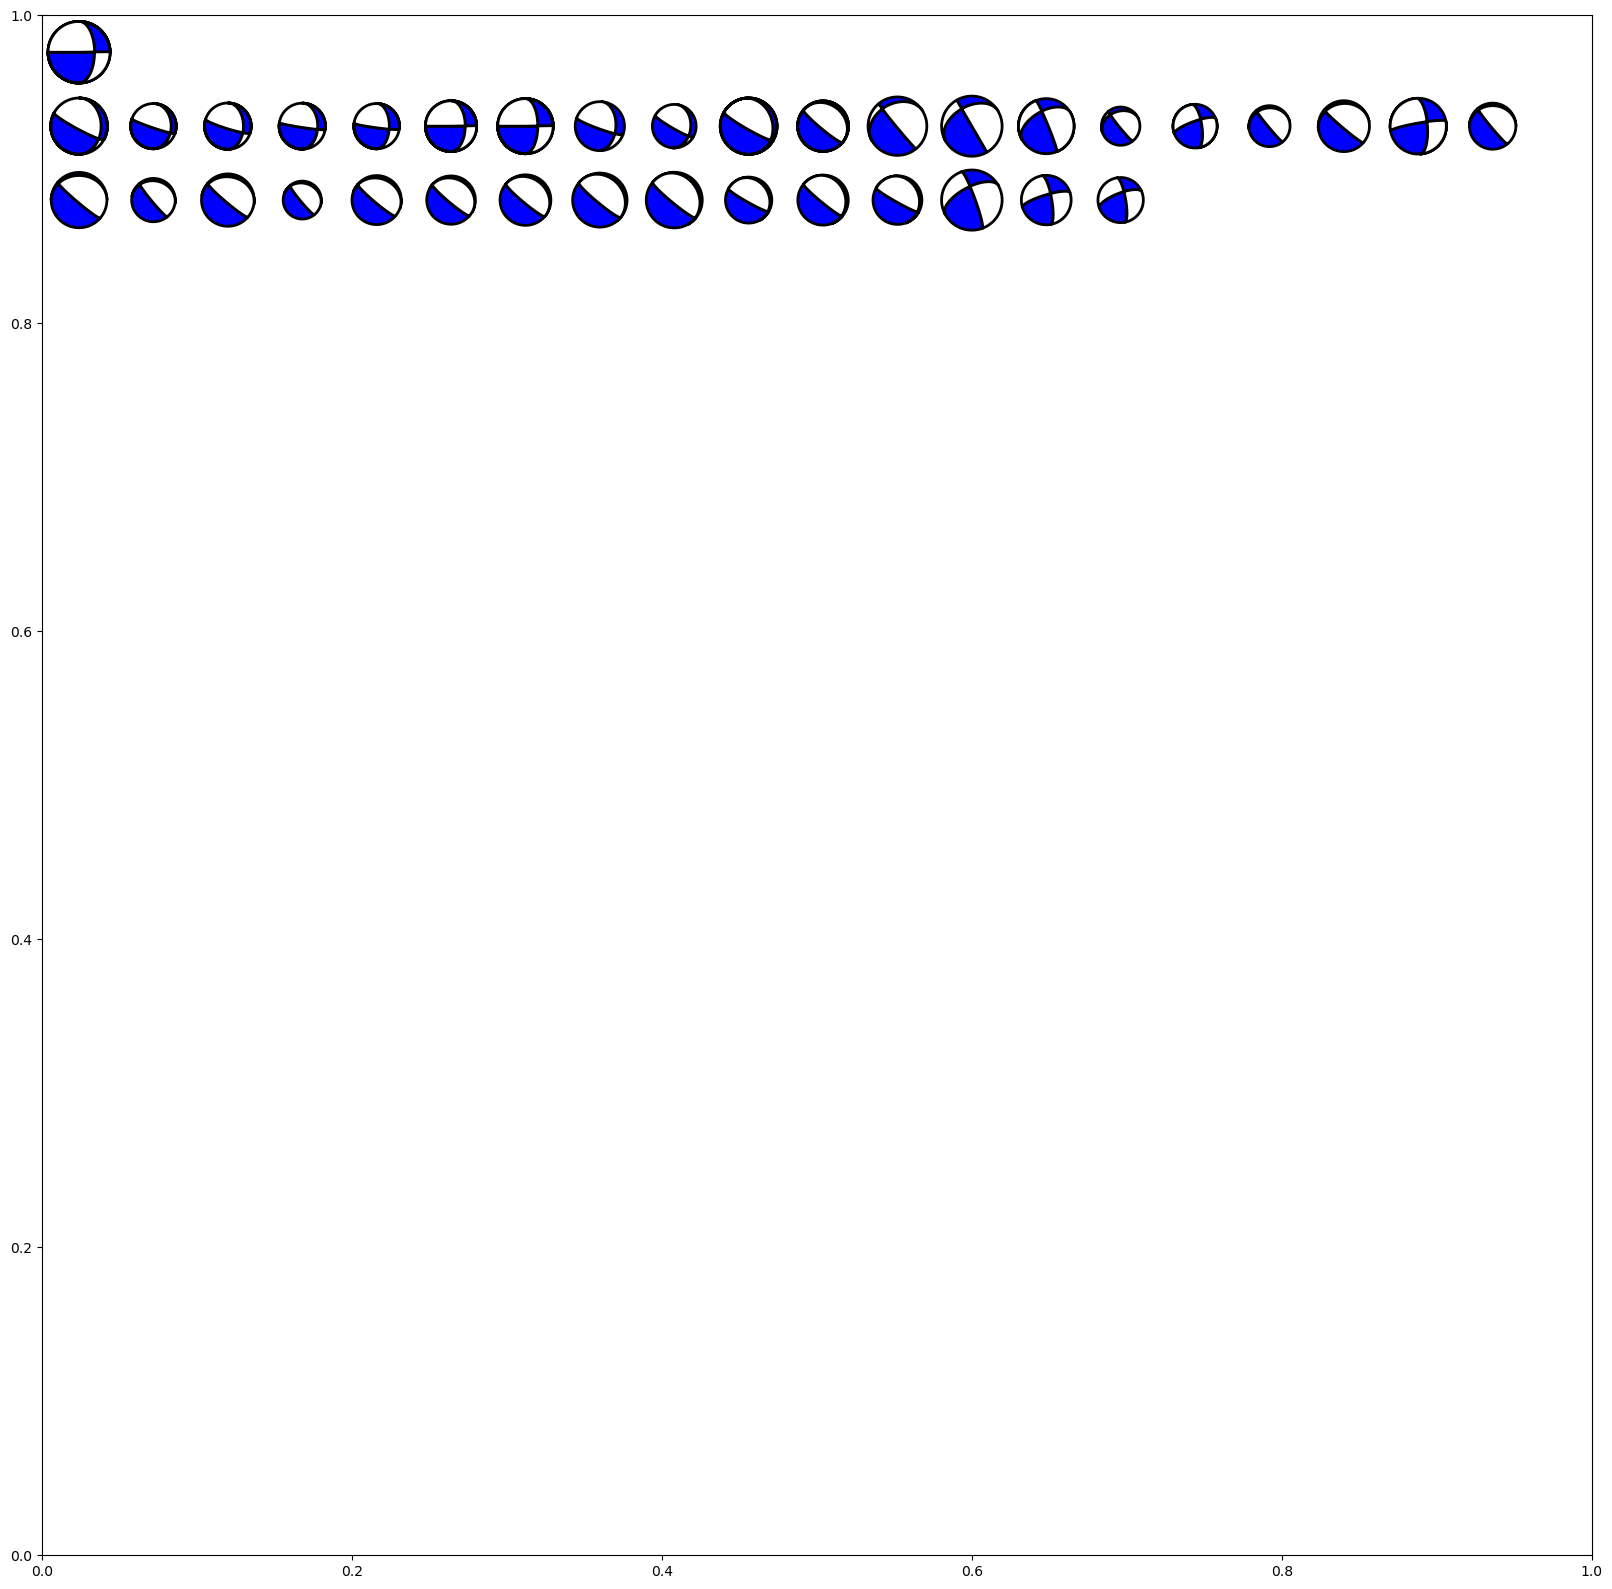

In [ ]:

bbo = sdr_all[ibb][0]    # real ("observed")
bba = sdr_all[ibb][1]    # all acceptable solutions

fbb, ax = plt.subplots(1, 1, figsize=(20, 20))    # default seems to be 0<x<1 and 0<y<1
wd = 0.04        # width of beachball in plot
offset = 1.2*wd  # space between beachballs in plot
x0 = offset/2    # coordinates of reference (real, observed) beachball -- top left
y0 = 1-offset/2

# plot "real" beachball:
b=beach(bbo, xy = (x0,y0), width=wd)
ax.add_collection(b)
# b=beach([1,-0.5,-0.5,0,0,0], xy = (x0+offset,y0), width=wd)
# ax.add_collection(b)
# b=beach([-1,0.5,0.5,0,0,0], xy = (x0+2*offset,y0), width=wd)
# ax.add_collection(b)

# plot acceptable bachballs. Adjust width of beachball plotted to scale with value of cossim (goodness of fit)
x = x0
y = y0-offset
for bb, cossim in bba:
    xy = (x, y)
    b = beach(bb, xy=xy, width=20*(cossim-0.95)*wd)
    ax.add_collection(b)
    x = x + offset
    if x > int(0.8/wd)*offset:
        y = y - offset
        x = x0



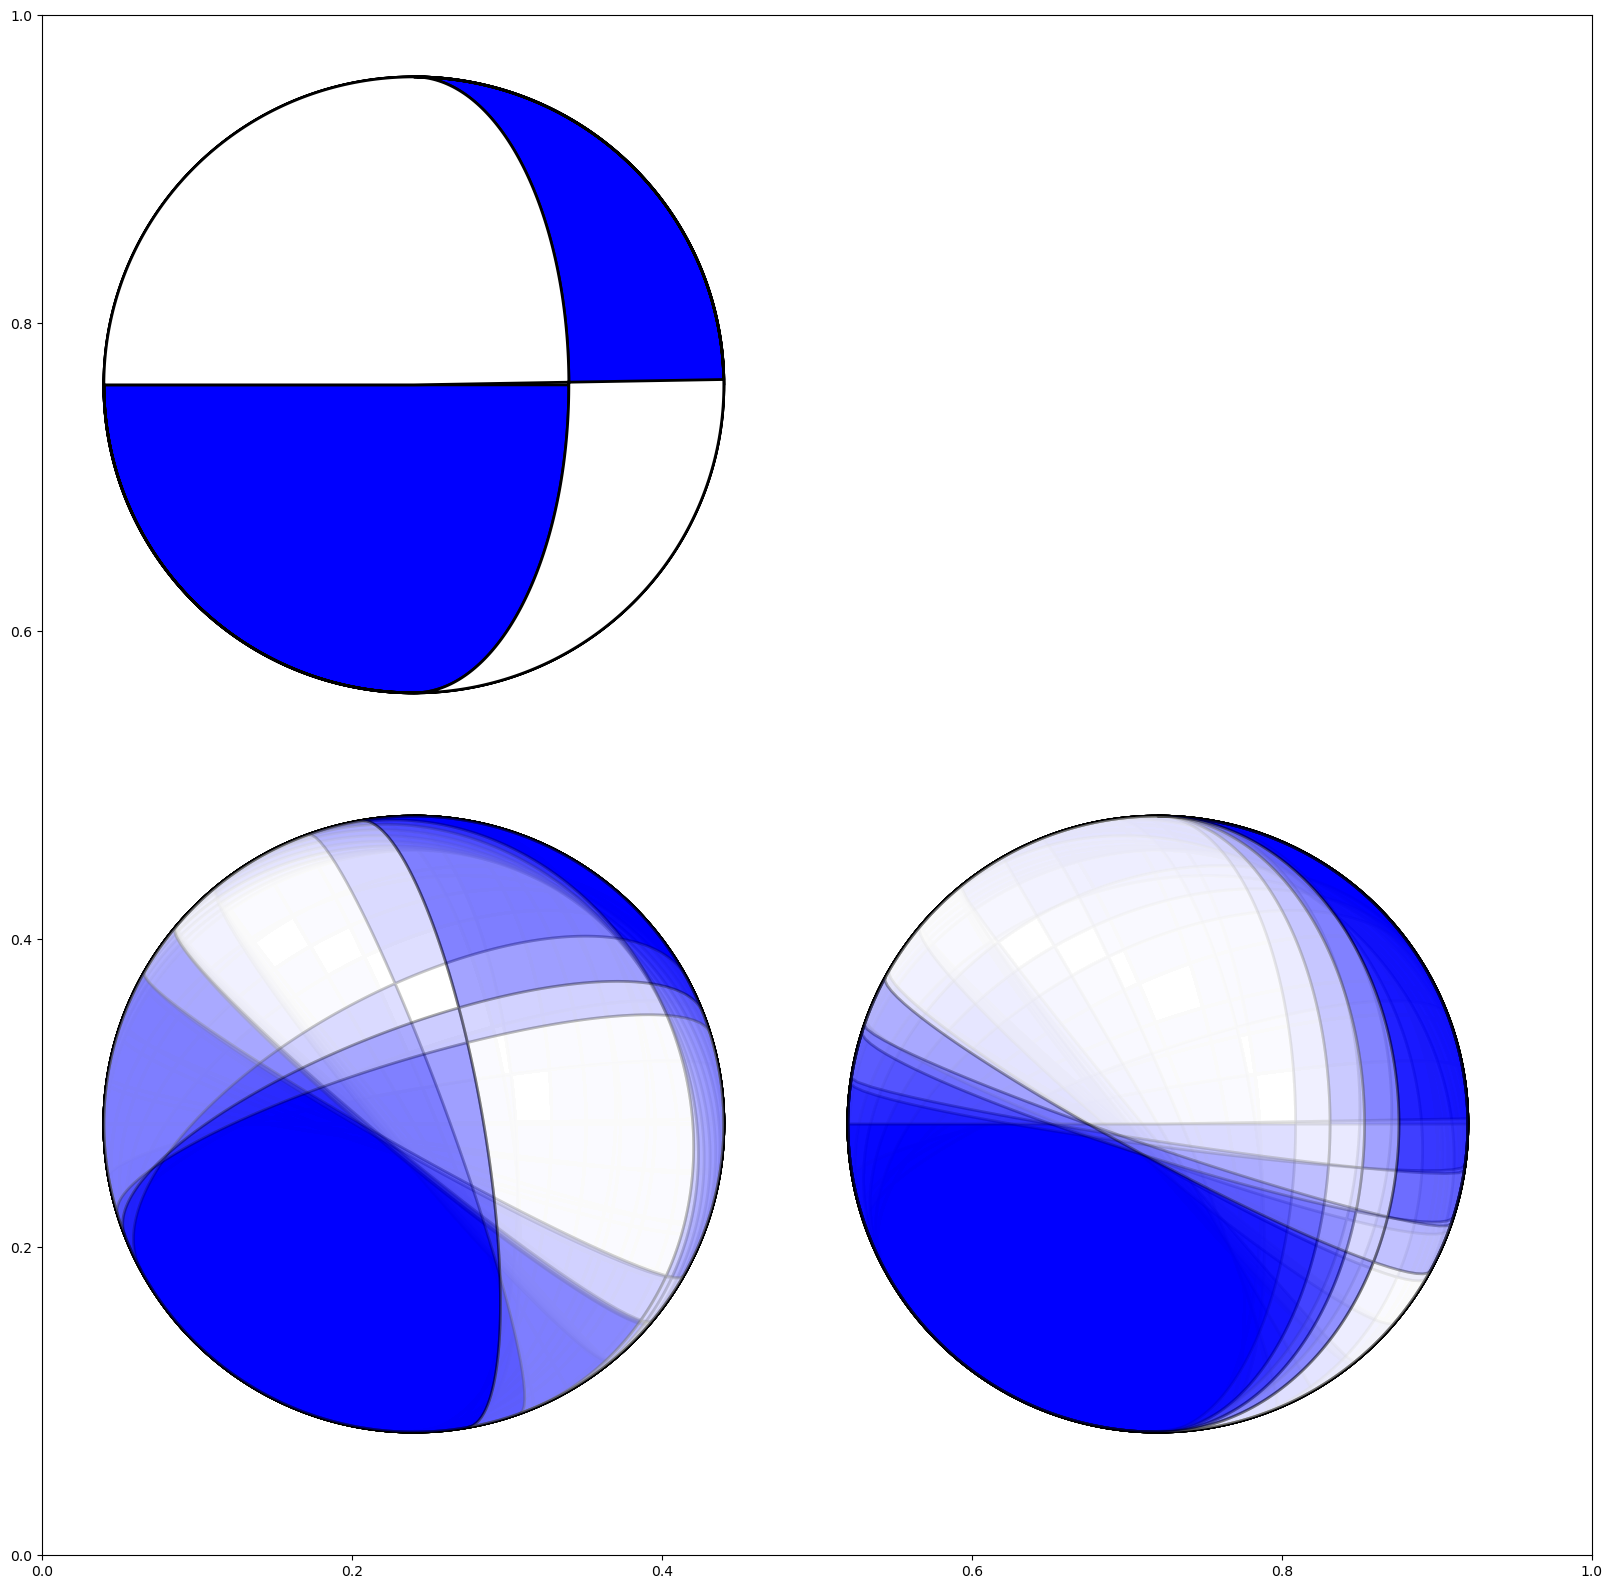

In [ ]:
bbo = sdr_all[ibb][0]
bba = sdr_all[ibb][1]
# bbaf, cossimf = sdr_all[ibb][1][0]
# bbal, cossiml = sdr_all[ibb][1][-1]

fbb, ax = plt.subplots(1, 1, figsize=(20, 20))
a = 0.2
wd = 0.4
offset = 1.2*wd
x0 = offset/2
y0 = 1-offset/2

b=beach(bbo, xy = (x0,y0), width=wd, alpha=1)
ax.add_collection(b)
# b=beach(bbaf, xy = (x0,y0), width=wd, alpha=a)
# ax.add_collection(b)
# b=beach(bbal, xy = (x0,y0), width=wd, alpha=a)
# ax.add_collection(b)

# now plot all acceptable beachballs transparently and in same location.
x=x0
y = y0-offset
for bb, cossim in bba:
    b=beach(bb, xy = (x,y), width=wd, alpha=a) 
    ax.add_collection(b)

# now plot all acceptable beachballs transparently and in same location, but in reverse order
y = y0-offset
x = x0 + offset
for bb, cossim in bba[::-1]:
    b=beach(bb, xy = (x,y), width=wd, alpha=a)
    ax.add_collection(b)

# the bottom two plots shoudl be the same but they are not.
# plotting order matters.



In [7]:
bbo

NameError: name 'bbo' is not defined

In [14]:
bbo = sdr_all[ibb][0]
bba = sdr_all[ibb][1]

fbb, ax = plt.subplots(1, 1, figsize=(20, 20))
a = 0.2
wd = 0.4
offset = 1.2*wd
x0 = offset/2
y0 = 1-offset/2

b=beach(bbo, xy = (x0,y0), width=wd, alpha=1)
ax.add_collection(b)


# fix plotting order issue by ordering beachballs according to goodness of fit:
x=x0
y = y0-offset
for bb, cossim in bba:
    b=beach(bb, xy = (x,y), width=wd, alpha=a, zorder=2000*(cossim-0.95)) 
    ax.add_collection(b)

y = y0-offset
x = x0 + offset
for bb, cossim in bba[::-1]:
    b=beach(bb, xy = (x,y), width=wd, alpha=a, zorder=2000*(cossim-0.95))
    ax.add_collection(b)



NameError: name 'sdr_all' is not defined